In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MS983/Datasets/ISOT/

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_nlp as knlp
from keras_nlp.models import BertBackbone, BertClassifier
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics
import time

# Load the dataset
df = pd.read_csv('Cleaned_Data.csv')[['text','label']].dropna()
texts = df['text'].tolist()
labels = df['label'].values

# Preprocess the text data using BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

# Convert the encodings to numpy arrays
ids   = np.array(encodings["input_ids"])
mask  = np.array(encodings["attention_mask"])
labels  = np.array(labels)
segs  = np.zeros_like(ids)

# Split the dataset into training, validation, and test sets
X_temp_ids, X_test_ids, X_temp_msk, X_test_msk, X_temp_seg, X_test_seg, y_temp, y_test = train_test_split(
    ids, mask, segs, labels,
    test_size=0.2, random_state=42, stratify=labels
)

X_train_ids, X_val_ids, X_train_msk, X_val_msk, X_train_seg, X_val_seg, y_train, y_val = train_test_split(
    X_temp_ids, X_temp_msk, X_temp_seg, y_temp,
    test_size=0.2, random_state=42, stratify=y_temp
)

# Convert the data into a format suitable for Keras
train_x = {"token_ids": X_train_ids, "padding_mask": X_train_msk, "segment_ids": X_train_seg}
val_x   = {"token_ids": X_val_ids,   "padding_mask": X_val_msk,   "segment_ids": X_val_seg}
test_x  = {"token_ids": X_test_ids,  "padding_mask": X_test_msk,  "segment_ids": X_test_seg}


/content/drive/MyDrive/MS983/Datasets/ISOT


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Define the model creation function for Optuna
def create_model(trial):
    lr           = trial.suggest_float("lr", 1e-5, 5e-4, log=True) # Learning rate
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.05) # Weight decay
    head_dropout = trial.suggest_float("head_dropout", 0.0, 0.4) # Head dropout
    last_n_trainable = trial.suggest_categorical("last_n_trainable", [0, 1, 2, 4, 12]) # Number of last layers to train

    backbone = knlp.models.BertBackbone.from_preset("bert_base_en_uncased") # Load the BERT backbone

    # Create the BERT classifier model
    model = knlp.models.BertClassifier(
        backbone=backbone,
        num_classes=1,
        activation=None, # No activation for binary classification
        dropout=head_dropout, 
    )

    # Freeze all layers except the last 'last_n_trainable' layers
    num_layers = backbone.num_layers
    for i, layer in enumerate(backbone.transformer_layers):
        layer.trainable = (i >= num_layers - last_n_trainable)

    # Compile the model with AdamW optimizer and binary crossentropy loss
    model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.0)]
    )
    return model

# Define the objective function for Optuna
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 24, 32]) # Batch size
    max_epochs = trial.suggest_int("max_epochs", 2, 5) # Maximum number of epochs

    # Create the model using the trial parameters
    model = create_model(trial)

    # Define callbacks for early stopping and pruning
    early  = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
    prune  = TFKerasPruningCallback(trial, monitor="val_accuracy")

    # Train the model
    history = model.fit(
        train_x, y_train,
        validation_data=(val_x, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[early, prune],
        verbose=0,
    )

    # Evaluate the model on the validation set
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
print(study.best_trial.params)


[I 2025-08-15 11:35:39,068] A new study created in memory with name: no-name-5c0651b9-f846-4640-9f2d-b9e252319c1e
[I 2025-08-15 11:40:33,118] Trial 0 finished with value: 0.9884433150291443 and parameters: {'batch_size': 24, 'max_epochs': 5, 'lr': 3.274450870277388e-05, 'weight_decay': 0.019244936123379238, 'head_dropout': 0.15165665842985754, 'last_n_trainable': 0}. Best is trial 0 with value: 0.9884433150291443.
[I 2025-08-15 11:48:02,625] Trial 1 finished with value: 0.990531861782074 and parameters: {'batch_size': 24, 'max_epochs': 3, 'lr': 0.0004329867431398728, 'weight_decay': 0.01705624338547985, 'head_dropout': 0.3612588079826913, 'last_n_trainable': 2}. Best is trial 1 with value: 0.990531861782074.
[I 2025-08-15 11:55:46,086] Trial 2 finished with value: 0.9915065169334412 and parameters: {'batch_size': 32, 'max_epochs': 4, 'lr': 3.0469770717513165e-05, 'weight_decay': 0.027383010829215328, 'head_dropout': 0.35183292610218997, 'last_n_trainable': 0}. Best is trial 2 with valu

100%|██████████| 418M/418M [00:27<00:00, 16.1MB/s]
[I 2025-08-15 12:10:20,748] Trial 3 finished with value: 0.9935951232910156 and parameters: {'batch_size': 32, 'max_epochs': 5, 'lr': 9.051070364767372e-05, 'weight_decay': 0.00033224857292400435, 'head_dropout': 0.2356471668194971, 'last_n_trainable': 12}. Best is trial 3 with value: 0.9935951232910156.
[I 2025-08-15 12:17:18,812] Trial 4 finished with value: 0.9967975616455078 and parameters: {'batch_size': 8, 'max_epochs': 5, 'lr': 4.758263142834146e-05, 'weight_decay': 0.016221044594446895, 'head_dropout': 0.28132537678228337, 'last_n_trainable': 4}. Best is trial 4 with value: 0.9967975616455078.
[I 2025-08-15 12:23:37,934] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-08-15 12:30:17,733] Trial 6 finished with value: 0.9942913055419922 and parameters: {'batch_size': 16, 'max_epochs': 4, 'lr': 9.216230258482848e-05, 'weight_decay': 0.03596176111955134, 'head_dropout': 0.25787424951336096, 'last_n_trainable': 4}. Best is tria

Best trial:
{'batch_size': 8, 'max_epochs': 5, 'lr': 4.758263142834146e-05, 'weight_decay': 0.016221044594446895, 'head_dropout': 0.28132537678228337, 'last_n_trainable': 4}


In [ ]:
# Extract the best parameters from the study
best_params = study.best_trial.params

lr = best_params['lr']
weight_decay = best_params['weight_decay']
head_dropout = best_params['head_dropout']
last_n_trainable = best_params['last_n_trainable']
batch_size = best_params['batch_size']
max_epochs = best_params['max_epochs']

# Create the final model with the best parameters
backbone = knlp.models.BertBackbone.from_preset("bert_base_en_uncased")
model = knlp.models.BertClassifier(
        backbone=backbone,
        num_classes=1,
        activation=None,      
        dropout=head_dropout,  
    )

early  = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.0)],
)

earlystop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)

history = model.fit(
    train_x, y_train,
    validation_data=(val_x, y_val),
    batch_size=batch_size,
    epochs=max_epochs,
    shuffle=True,
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/5
3591/3591 ━━━━━━━━━━━━━━━━━━━━ 355s 78ms/step - accuracy: 0.9673 - loss: 0.0926 - val_accuracy: 0.9916 - val_loss: 0.0288
Epoch 2/5
3591/3591 ━━━━━━━━━━━━━━━━━━━━ 267s 74ms/step - accuracy: 0.9899 - loss: 0.0348 - val_accuracy: 0.9922 - val_loss: 0.0340


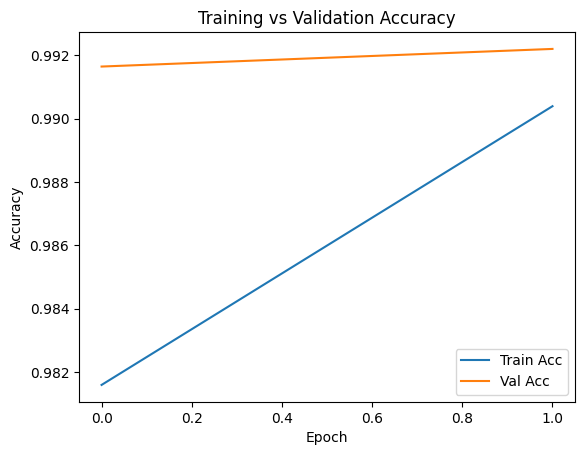

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


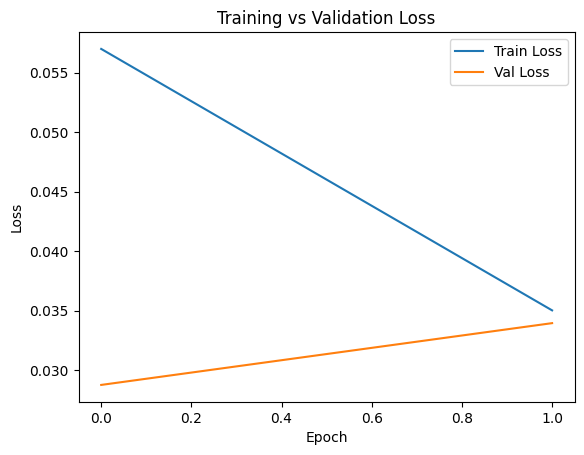

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_x, y_test, batch_size=16)
print(f"Test accuracy: {test_acc:.3f}")


562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9933 - loss: 0.0241
Test accuracy: 0.993


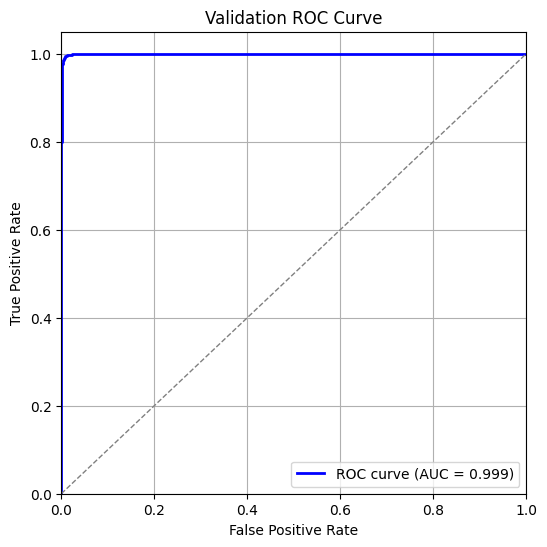

In [ ]:
# Predict probabilities on the validation set
val_logits = model.predict(val_x, batch_size=16, verbose=0).ravel()
val_probs  = tf.sigmoid(tf.constant(val_logits)).numpy()

# Compute ROC curve & AUC
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
print("Test Performance:")

start_test = time.time() # Start timing the test inference

# Predict probabilities on the test set
logits = model.predict(test_x, batch_size=16, verbose=0).squeeze()
test_proba = tf.sigmoid(tf.convert_to_tensor(logits)).numpy().ravel()

test_pred = (test_proba >= 0.5).astype(int) # Use 0.5 threshold for binary classification

end_test = time.time() # End timing the test inference

test_time = end_test - start_test
test_avg_time = test_time / len(y_test)

print(classification_report(y_test.astype(int), test_pred, digits=2))
print(f"Test inference time: {test_time:.4f} seconds")
print(f"Average time per test sample: {test_avg_time:.6f} seconds")

Test Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4694
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978

Test inference time: 23.6468 seconds
Average time per test sample: 0.002634 seconds


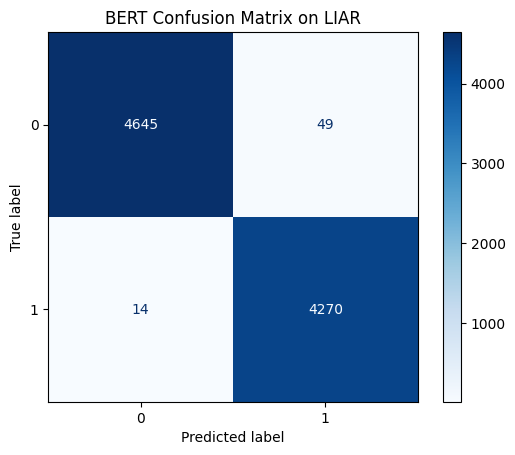

In [ ]:
# Compute confusion matri
confusion_matrix = metrics.confusion_matrix(y_test, test_pred)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot(cmap="Blues", values_format='d')
plt.title("BERT Confusion Matrix on ISOT")
plt.show()

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/MS983/Models/isot_bert.keras")

In [ ]:
%cd /content/drive/MyDrive/MS983/Models/

# Load the model
model = tf.keras.models.load_model("isot_bert.keras")

/content/drive/MyDrive/MS983/Models


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 404 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
